# Anomaly Detection using PyOD

## Assignment Part E

This notebook demonstrates anomaly detection using the PyOD (Python Outlier Detection) library for both univariate and multivariate time series data.

### What is Anomaly Detection?
Anomaly detection identifies rare items, events, or observations that raise suspicions by differing significantly from the majority of the data.

### Applications:
- Fraud detection in financial transactions
- Network intrusion detection
- Manufacturing quality control
- Health monitoring
- Predictive maintenance

### PyOD Library:
PyOD is a comprehensive Python library for detecting outliers in multivariate data. It includes:
- 40+ outlier detection algorithms
- Unified API
- Combination frameworks
- Evaluation metrics

## 1. Installation and Setup

In [1]:
# Install required libraries
!pip install pyod -q
!pip install pandas numpy matplotlib seaborn scikit-learn -q
!pip install plotly -q

print("Installation complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.6/200.6 kB 10.7 MB/s eta 0:00:00
Installation complete!


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# PyOD imports
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA as PCA_OD
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import evaluate_print

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Univariate Anomaly Detection

We'll detect anomalies in single-variable time series data using temperature sensor readings.

In [3]:
# Generate synthetic univariate time series data (temperature sensor)
np.random.seed(42)

# Create time index
start_date = datetime(2024, 1, 1)
time_index = pd.date_range(start=start_date, periods=1000, freq='H')

# Generate normal temperature readings with daily pattern
base_temp = 20  # Base temperature
daily_variation = 5 * np.sin(2 * np.pi * np.arange(1000) / 24)  # Daily cycle
noise = np.random.normal(0, 1, 1000)  # Random noise
temperature = base_temp + daily_variation + noise

# Inject anomalies
anomaly_indices = [100, 250, 400, 550, 700, 850]  # Anomaly positions
for idx in anomaly_indices:
    temperature[idx] += np.random.choice([-15, 15])  # Extreme temperature spikes/drops

# Create DataFrame
df_univariate = pd.DataFrame({
    'timestamp': time_index,
    'temperature': temperature
})

# Create ground truth labels (0: normal, 1: anomaly)
y_true_uni = np.zeros(1000)
y_true_uni[anomaly_indices] = 1

print(f"Dataset shape: {df_univariate.shape}")
print(f"Number of anomalies: {int(y_true_uni.sum())}")
print(f"Anomaly percentage: {(y_true_uni.sum()/len(y_true_uni))*100:.2f}%")

display(df_univariate.head(10))
print("\nBasic statistics:")
display(df_univariate.describe())

Dataset shape: (1000, 2)
Number of anomalies: 6
Anomaly percentage: 0.60%


,timestamp,temperature
0,2024-01-01 00:00:00,20.496714
1,2024-01-01 01:00:00,21.155831
2,2024-01-01 02:00:00,23.147689
3,2024-01-01 03:00:00,25.058564
4,2024-01-01 04:00:00,24.095974
5,2024-01-01 05:00:00,24.595492
6,2024-01-01 06:00:00,26.579213
7,2024-01-01 07:00:00,25.597064
8,2024-01-01 08:00:00,23.860653
9,2024-01-01 09:00:00,24.078094



Basic statistics:


,timestamp,temperature
count,1000,1000.000000
mean,2024-01-21 19:29:59.999999744,20.019981
min,2024-01-01 00:00:00,-0.924555
25%,2024-01-11 09:45:00,16.621598
50%,2024-01-21 19:30:00,20.156716
75%,2024-02-01 05:15:00,23.471771
max,2024-02-11 15:00:00,36.239116
std,NaN,3.825410


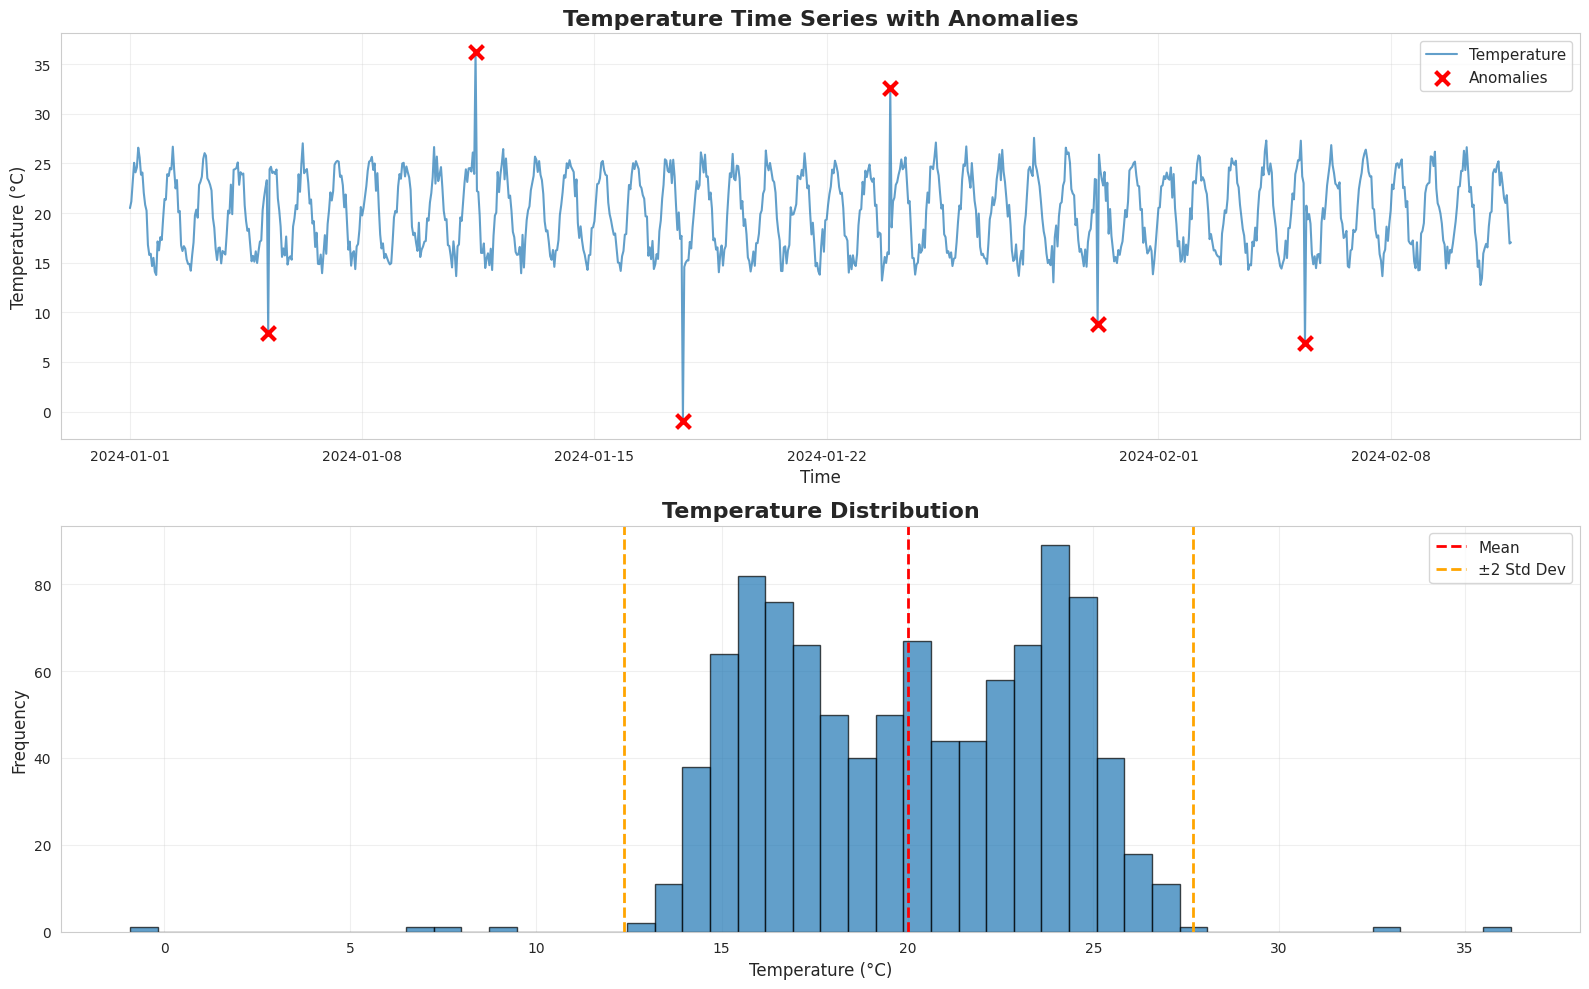

In [4]:
# Visualize univariate data
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Plot 1: Full time series
axes[0].plot(df_univariate['timestamp'], df_univariate['temperature'],
             linewidth=1.5, alpha=0.7, label='Temperature')
axes[0].scatter(df_univariate.iloc[anomaly_indices]['timestamp'],
               df_univariate.iloc[anomaly_indices]['temperature'],
               color='red', s=100, marker='x', linewidths=3,
               label='Anomalies', zorder=5)
axes[0].set_title('Temperature Time Series with Anomalies', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Time', fontsize=12)
axes[0].set_ylabel('Temperature (°C)', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution
axes[1].hist(df_univariate['temperature'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(df_univariate['temperature'].mean(), color='red',
                linestyle='--', linewidth=2, label='Mean')
axes[1].axvline(df_univariate['temperature'].mean() + 2*df_univariate['temperature'].std(),
                color='orange', linestyle='--', linewidth=2, label='±2 Std Dev')
axes[1].axvline(df_univariate['temperature'].mean() - 2*df_univariate['temperature'].std(),
                color='orange', linestyle='--', linewidth=2)
axes[1].set_title('Temperature Distribution', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Temperature (°C)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [5]:
# Prepare data for anomaly detection
X_uni = df_univariate[['temperature']].values

# Standardize the data
scaler_uni = StandardScaler()
X_uni_scaled = scaler_uni.fit_transform(X_uni)

# Apply multiple anomaly detection algorithms
algorithms_uni = {
    'Isolation Forest': IForest(contamination=0.01, random_state=42),
    'KNN': KNN(contamination=0.01),
    'LOF': LOF(contamination=0.01),
    'One-Class SVM': OCSVM(contamination=0.01)
}

results_uni = {}

print("Running anomaly detection algorithms...\n")
print("="*80)

for name, model in algorithms_uni.items():
    # Fit the model
    model.fit(X_uni_scaled)

    # Get predictions (0: inlier, 1: outlier)
    y_pred = model.predict(X_uni_scaled)

    # Get anomaly scores
    scores = model.decision_function(X_uni_scaled)

    # Store results
    results_uni[name] = {
        'predictions': y_pred,
        'scores': scores,
        'model': model
    }

    # Calculate metrics
    n_anomalies = y_pred.sum()
    true_positives = ((y_pred == 1) & (y_true_uni == 1)).sum()
    false_positives = ((y_pred == 1) & (y_true_uni == 0)).sum()
    precision = true_positives / n_anomalies if n_anomalies > 0 else 0
    recall = true_positives / y_true_uni.sum() if y_true_uni.sum() > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{name}:")
    print("-" * 80)
    print(f"  Detected anomalies: {n_anomalies}")
    print(f"  True positives: {true_positives}")
    print(f"  False positives: {false_positives}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

print("\n" + "="*80)

Running anomaly detection algorithms...


Isolation Forest:
--------------------------------------------------------------------------------
  Detected anomalies: 9
  True positives: 6
  False positives: 3
  Precision: 0.6667
  Recall: 1.0000
  F1-Score: 0.8000

KNN:
--------------------------------------------------------------------------------
  Detected anomalies: 9
  True positives: 6
  False positives: 3
  Precision: 0.6667
  Recall: 1.0000
  F1-Score: 0.8000

LOF:
--------------------------------------------------------------------------------
  Detected anomalies: 10
  True positives: 6
  False positives: 4
  Precision: 0.6000
  Recall: 1.0000
  F1-Score: 0.7500

One-Class SVM:
--------------------------------------------------------------------------------
  Detected anomalies: 10
  True positives: 6
  False positives: 4
  Precision: 0.6000
  Recall: 1.0000
  F1-Score: 0.7500



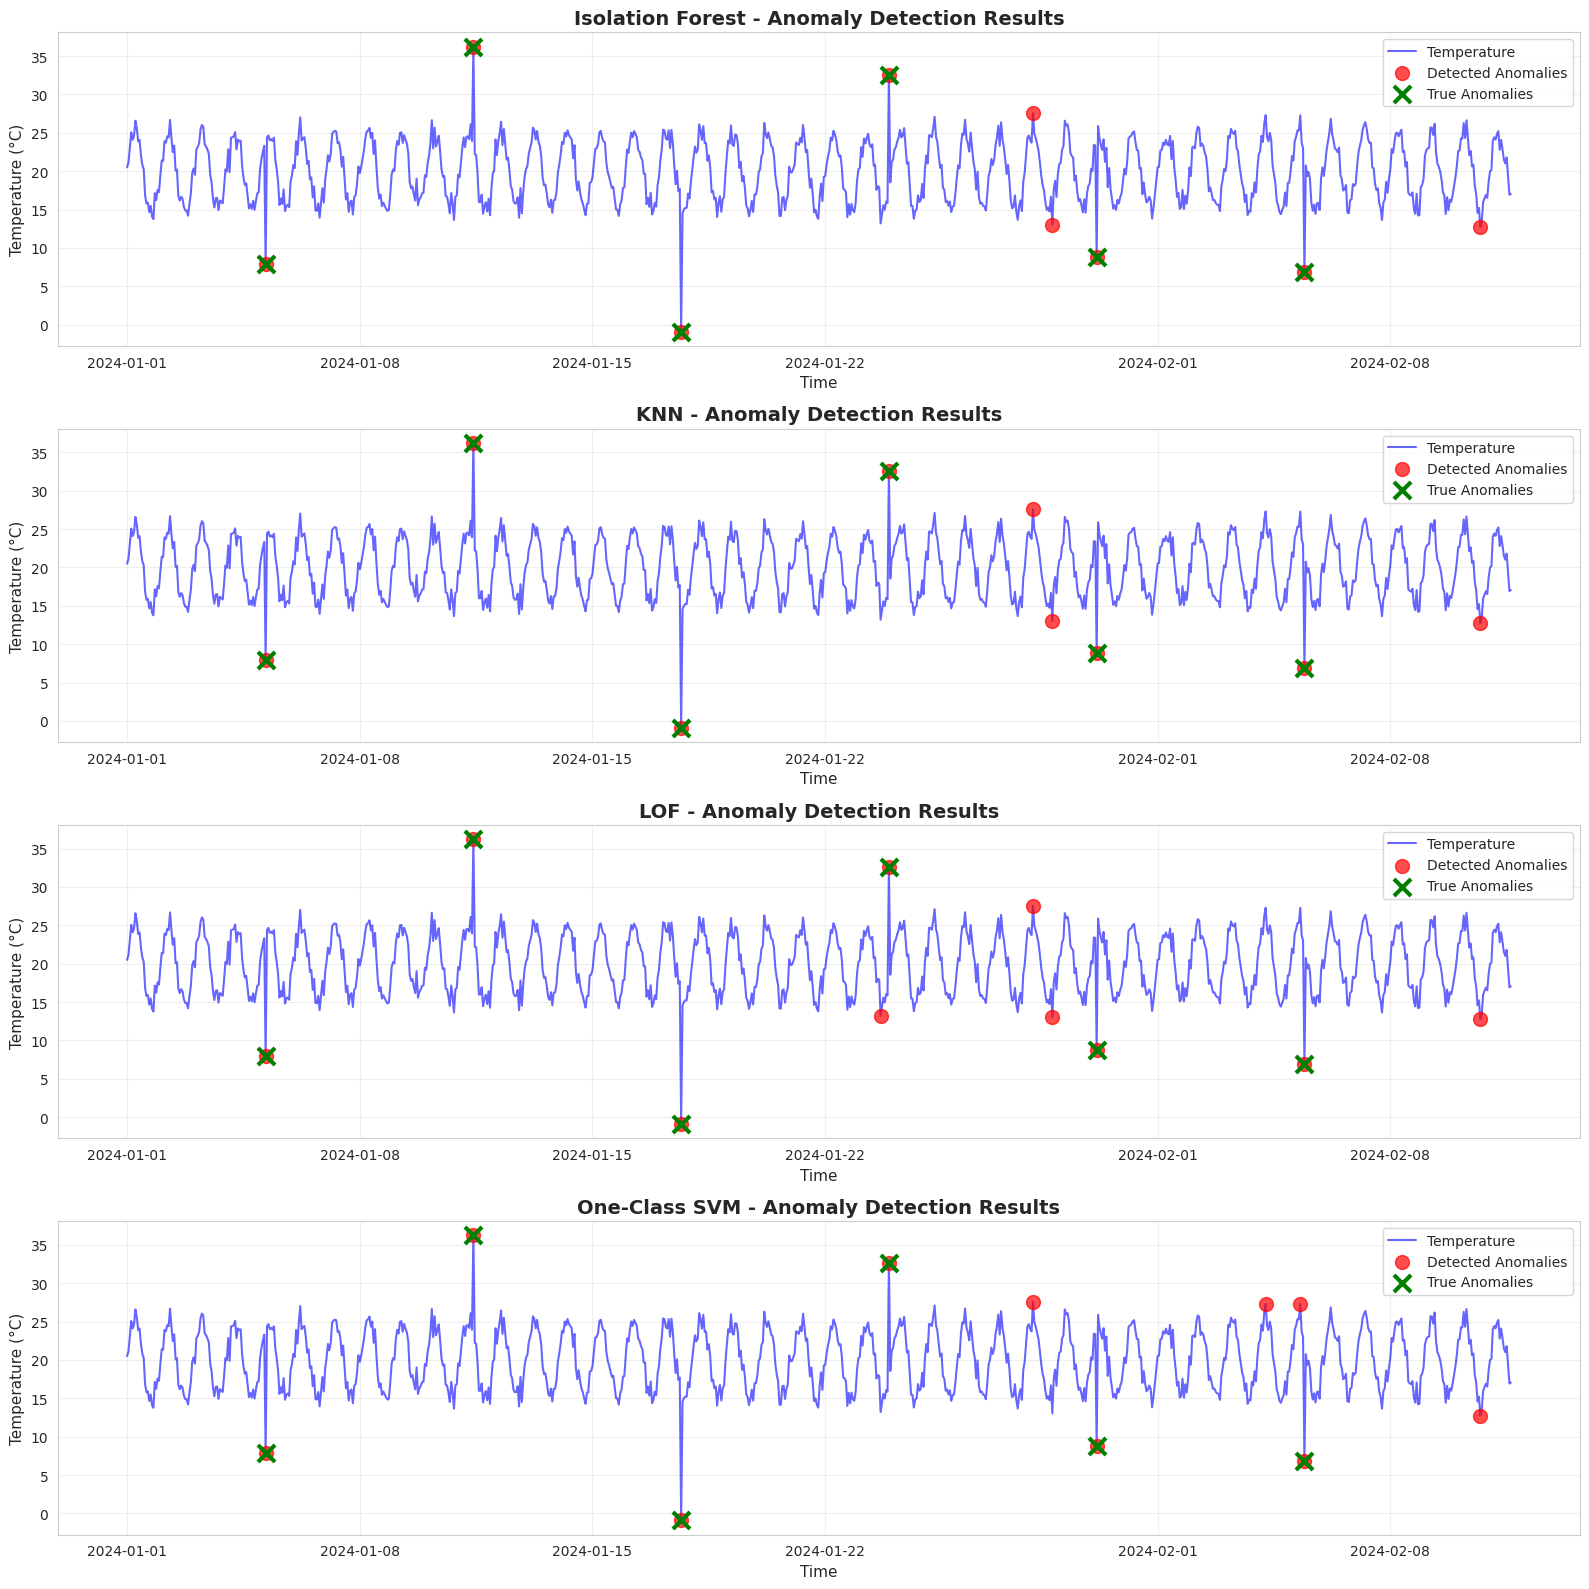

In [6]:
# Visualize results from all algorithms
fig, axes = plt.subplots(len(algorithms_uni), 1, figsize=(16, 4*len(algorithms_uni)))

if len(algorithms_uni) == 1:
    axes = [axes]

for idx, (name, result) in enumerate(results_uni.items()):
    y_pred = result['predictions']

    # Plot time series
    axes[idx].plot(df_univariate['timestamp'], df_univariate['temperature'],
                   linewidth=1.5, alpha=0.6, label='Temperature', color='blue')

    # Highlight detected anomalies
    anomaly_mask = y_pred == 1
    axes[idx].scatter(df_univariate[anomaly_mask]['timestamp'],
                      df_univariate[anomaly_mask]['temperature'],
                      color='red', s=100, marker='o', alpha=0.7,
                      label='Detected Anomalies', zorder=5)

    # Highlight true anomalies
    true_anomaly_mask = y_true_uni == 1
    axes[idx].scatter(df_univariate.iloc[anomaly_indices]['timestamp'],
                      df_univariate.iloc[anomaly_indices]['temperature'],
                      color='green', s=150, marker='x', linewidths=3,
                      label='True Anomalies', zorder=6)

    axes[idx].set_title(f'{name} - Anomaly Detection Results',
                        fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Time', fontsize=11)
    axes[idx].set_ylabel('Temperature (°C)', fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Multivariate Anomaly Detection

We'll detect anomalies in multi-variable time series data using server monitoring metrics (CPU, Memory, Network).

In [7]:
# Generate synthetic multivariate time series data (server monitoring)
np.random.seed(42)

n_samples = 1000
time_index = pd.date_range(start='2024-01-01', periods=n_samples, freq='5min')

# Generate normal patterns
cpu_usage = 40 + 10 * np.sin(2 * np.pi * np.arange(n_samples) / 288) + np.random.normal(0, 3, n_samples)
memory_usage = 60 + 5 * np.cos(2 * np.pi * np.arange(n_samples) / 288) + np.random.normal(0, 2, n_samples)
network_traffic = 30 + 15 * np.sin(2 * np.pi * np.arange(n_samples) / 144) + np.random.normal(0, 4, n_samples)

# Inject multivariate anomalies (correlated spikes)
anomaly_indices_multi = [150, 300, 450, 600, 750, 900]
for idx in anomaly_indices_multi:
    cpu_usage[idx:idx+3] += np.random.uniform(30, 40)
    memory_usage[idx:idx+3] += np.random.uniform(20, 30)
    network_traffic[idx:idx+3] += np.random.uniform(40, 50)

# Create DataFrame
df_multivariate = pd.DataFrame({
    'timestamp': time_index,
    'cpu_usage': cpu_usage,
    'memory_usage': memory_usage,
    'network_traffic': network_traffic
})

# Create ground truth labels
y_true_multi = np.zeros(n_samples)
for idx in anomaly_indices_multi:
    y_true_multi[idx:idx+3] = 1

print(f"Dataset shape: {df_multivariate.shape}")
print(f"Number of anomalies: {int(y_true_multi.sum())}")
print(f"Anomaly percentage: {(y_true_multi.sum()/len(y_true_multi))*100:.2f}%")

display(df_multivariate.head(10))
print("\nBasic statistics:")
display(df_multivariate.describe())

Dataset shape: (1000, 4)
Number of anomalies: 18
Anomaly percentage: 1.80%


,timestamp,cpu_usage,memory_usage,network_traffic
0,2024-01-01 00:00:00,41.490142,67.798711,27.299287
1,2024-01-01 00:05:00,39.803356,66.848078,30.076216
2,2024-01-01 00:10:00,42.379259,65.114502,28.137656
3,2024-01-01 00:15:00,45.223121,63.695421,30.726047
4,2024-01-01 00:20:00,40.169097,66.377420,25.030264
5,2024-01-01 00:25:00,40.386258,65.757252,34.099769
6,2024-01-01 00:30:00,46.042900,66.747611,33.887108
7,2024-01-01 00:35:00,43.823538,66.212151,31.242232
8,2024-01-01 00:40:00,40.328059,67.023144,37.767285
9,2024-01-01 00:45:00,43.578583,63.833456,39.490532



Basic statistics:


,timestamp,cpu_usage,memory_usage,network_traffic
count,1000,1000.000000,1000.000000,1000.000000
mean,2024-01-02 17:37:30,41.608055,60.639203,30.849123
min,2024-01-01 00:00:00,24.457641,50.302725,5.094257
25%,2024-01-01 20:48:45,34.265250,57.171143,20.130654
50%,2024-01-02 17:37:30,42.040721,60.334874,29.967244
75%,2024-01-03 14:26:15,47.809104,63.517033,40.387607
max,2024-01-04 11:15:00,86.412610,93.931162,95.102878
std,NaN,8.972265,5.122458,13.568613


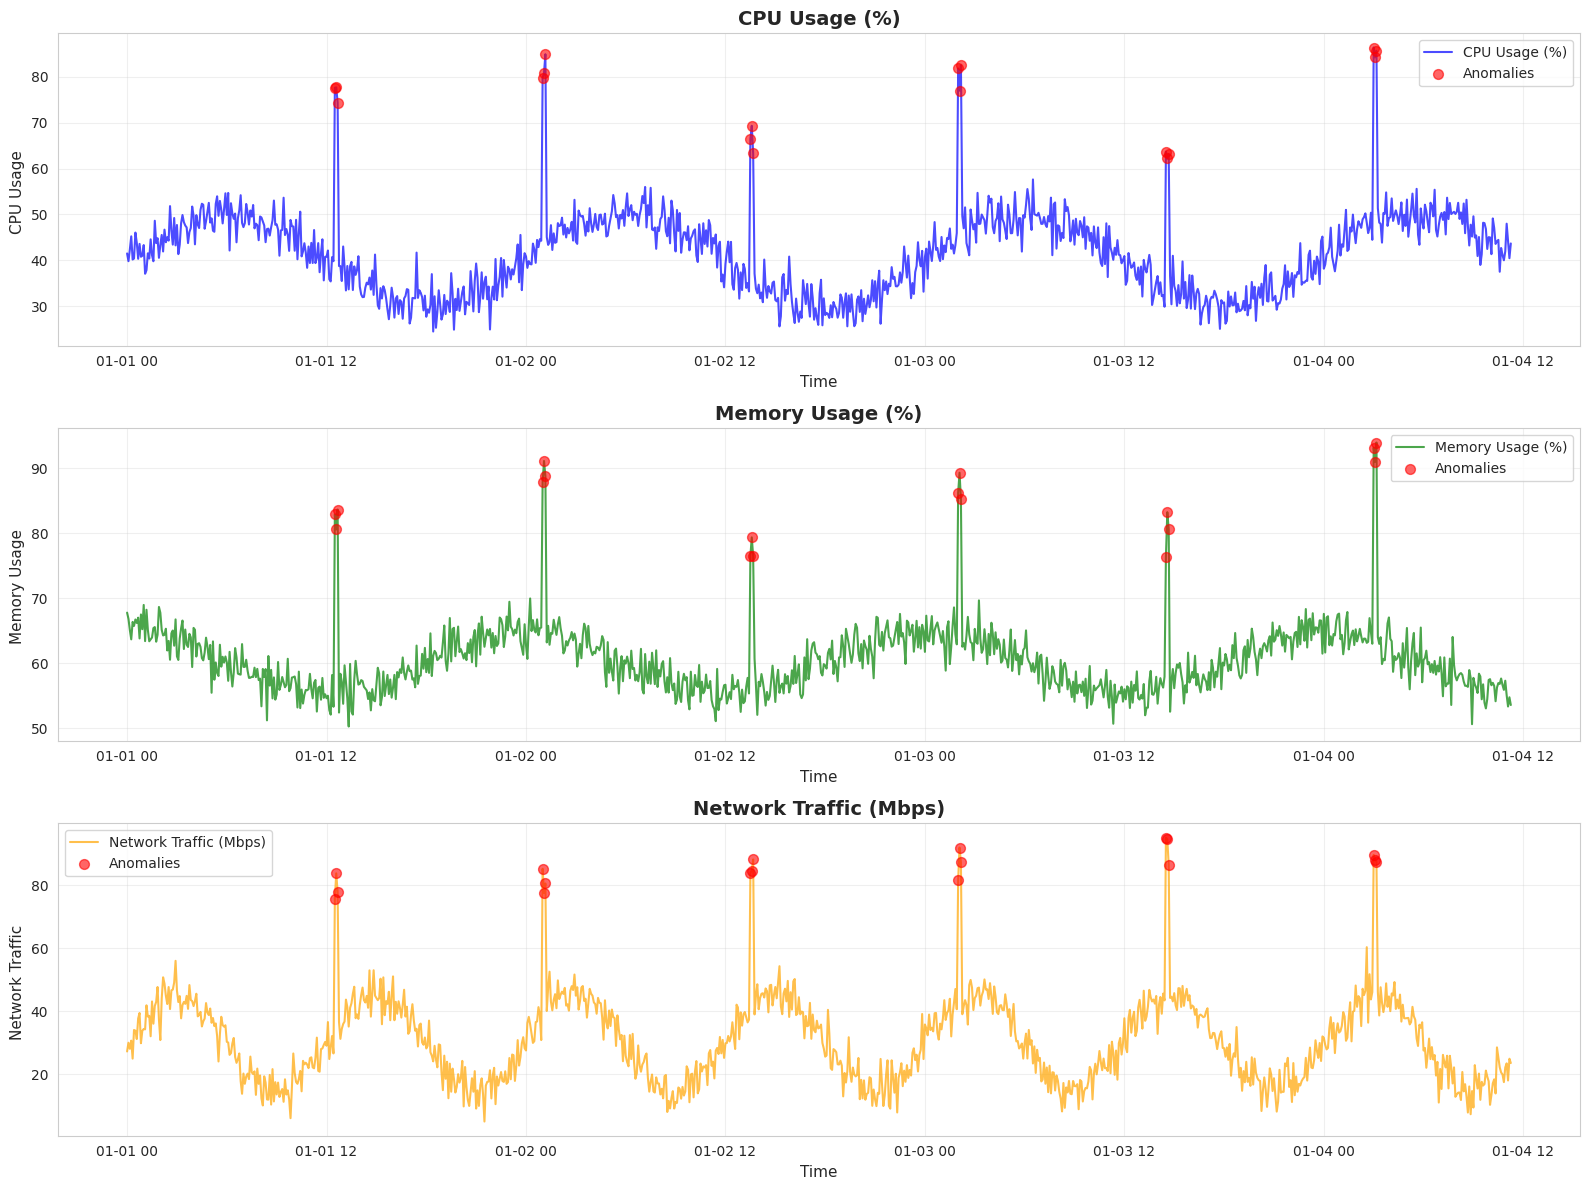

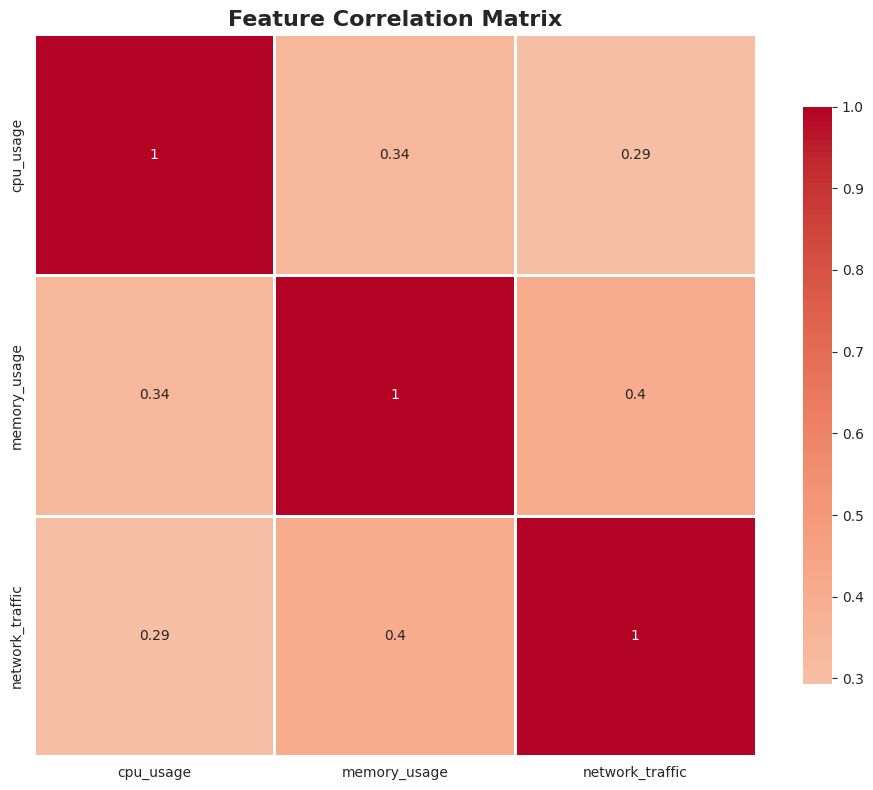

In [8]:
# Visualize multivariate data
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

metrics = ['cpu_usage', 'memory_usage', 'network_traffic']
colors = ['blue', 'green', 'orange']
labels = ['CPU Usage (%)', 'Memory Usage (%)', 'Network Traffic (Mbps)']

for idx, (metric, color, label) in enumerate(zip(metrics, colors, labels)):
    axes[idx].plot(df_multivariate['timestamp'], df_multivariate[metric],
                   linewidth=1.5, alpha=0.7, color=color, label=label)

    # Highlight anomalous regions
    anomaly_mask = y_true_multi == 1
    axes[idx].scatter(df_multivariate[anomaly_mask]['timestamp'],
                      df_multivariate[anomaly_mask][metric],
                      color='red', s=50, alpha=0.6, label='Anomalies', zorder=5)

    axes[idx].set_title(label, fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Time', fontsize=11)
    axes[idx].set_ylabel(label.split('(')[0], fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df_multivariate[metrics].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
# Prepare data for multivariate anomaly detection
X_multi = df_multivariate[['cpu_usage', 'memory_usage', 'network_traffic']].values

# Standardize the data
scaler_multi = StandardScaler()
X_multi_scaled = scaler_multi.fit_transform(X_multi)

# Apply multiple anomaly detection algorithms
algorithms_multi = {
    'Isolation Forest': IForest(contamination=0.02, random_state=42),
    'KNN': KNN(contamination=0.02, n_neighbors=10),
    'LOF': LOF(contamination=0.02, n_neighbors=20),
    'CBLOF': CBLOF(contamination=0.02, n_clusters=8, random_state=42), # Changed n_clusters from 3 to 8
    'PCA': PCA_OD(contamination=0.02)
}

results_multi = {}

print("Running multivariate anomaly detection algorithms...\n")
print("="*80)

for name, model in algorithms_multi.items():
    print(f"\nTraining {name}...")

    # Fit the model
    model.fit(X_multi_scaled)

    # Get predictions
    y_pred = model.predict(X_multi_scaled)

    # Get anomaly scores
    scores = model.decision_function(X_multi_scaled)

    # Store results
    results_multi[name] = {
        'predictions': y_pred,
        'scores': scores,
        'model': model
    }

    # Calculate metrics
    n_anomalies = y_pred.sum()
    true_positives = ((y_pred == 1) & (y_true_multi == 1)).sum()
    false_positives = ((y_pred == 1) & (y_true_multi == 0)).sum()
    false_negatives = ((y_pred == 0) & (y_true_multi == 1)).sum()
    true_negatives = ((y_pred == 0) & (y_true_multi == 0)).sum()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (true_positives + true_negatives) / len(y_pred)

    print(f"\n{name} Results:")
    print("-" * 80)
    print(f"  Detected anomalies: {n_anomalies}")
    print(f"  True positives: {true_positives}")
    print(f"  False positives: {false_positives}")
    print(f"  False negatives: {false_negatives}")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

print("\n" + "="*80)


Running multivariate anomaly detection algorithms...


Training Isolation Forest...

Isolation Forest Results:
--------------------------------------------------------------------------------
  Detected anomalies: 20
  True positives: 18
  False positives: 2
  False negatives: 0
  Accuracy: 0.9980
  Precision: 0.9000
  Recall: 1.0000
  F1-Score: 0.9474

Training KNN...

KNN Results:
--------------------------------------------------------------------------------
  Detected anomalies: 20
  True positives: 18
  False positives: 2
  False negatives: 0
  Accuracy: 0.9980
  Precision: 0.9000
  Recall: 1.0000
  F1-Score: 0.9474

Training LOF...

LOF Results:
--------------------------------------------------------------------------------
  Detected anomalies: 5
  True positives: 3
  False positives: 2
  False negatives: 15
  Accuracy: 0.9830
  Precision: 0.6000
  Recall: 0.1667
  F1-Score: 0.2609

Training CBLOF...

CBLOF Results:
-------------------------------------------------------------

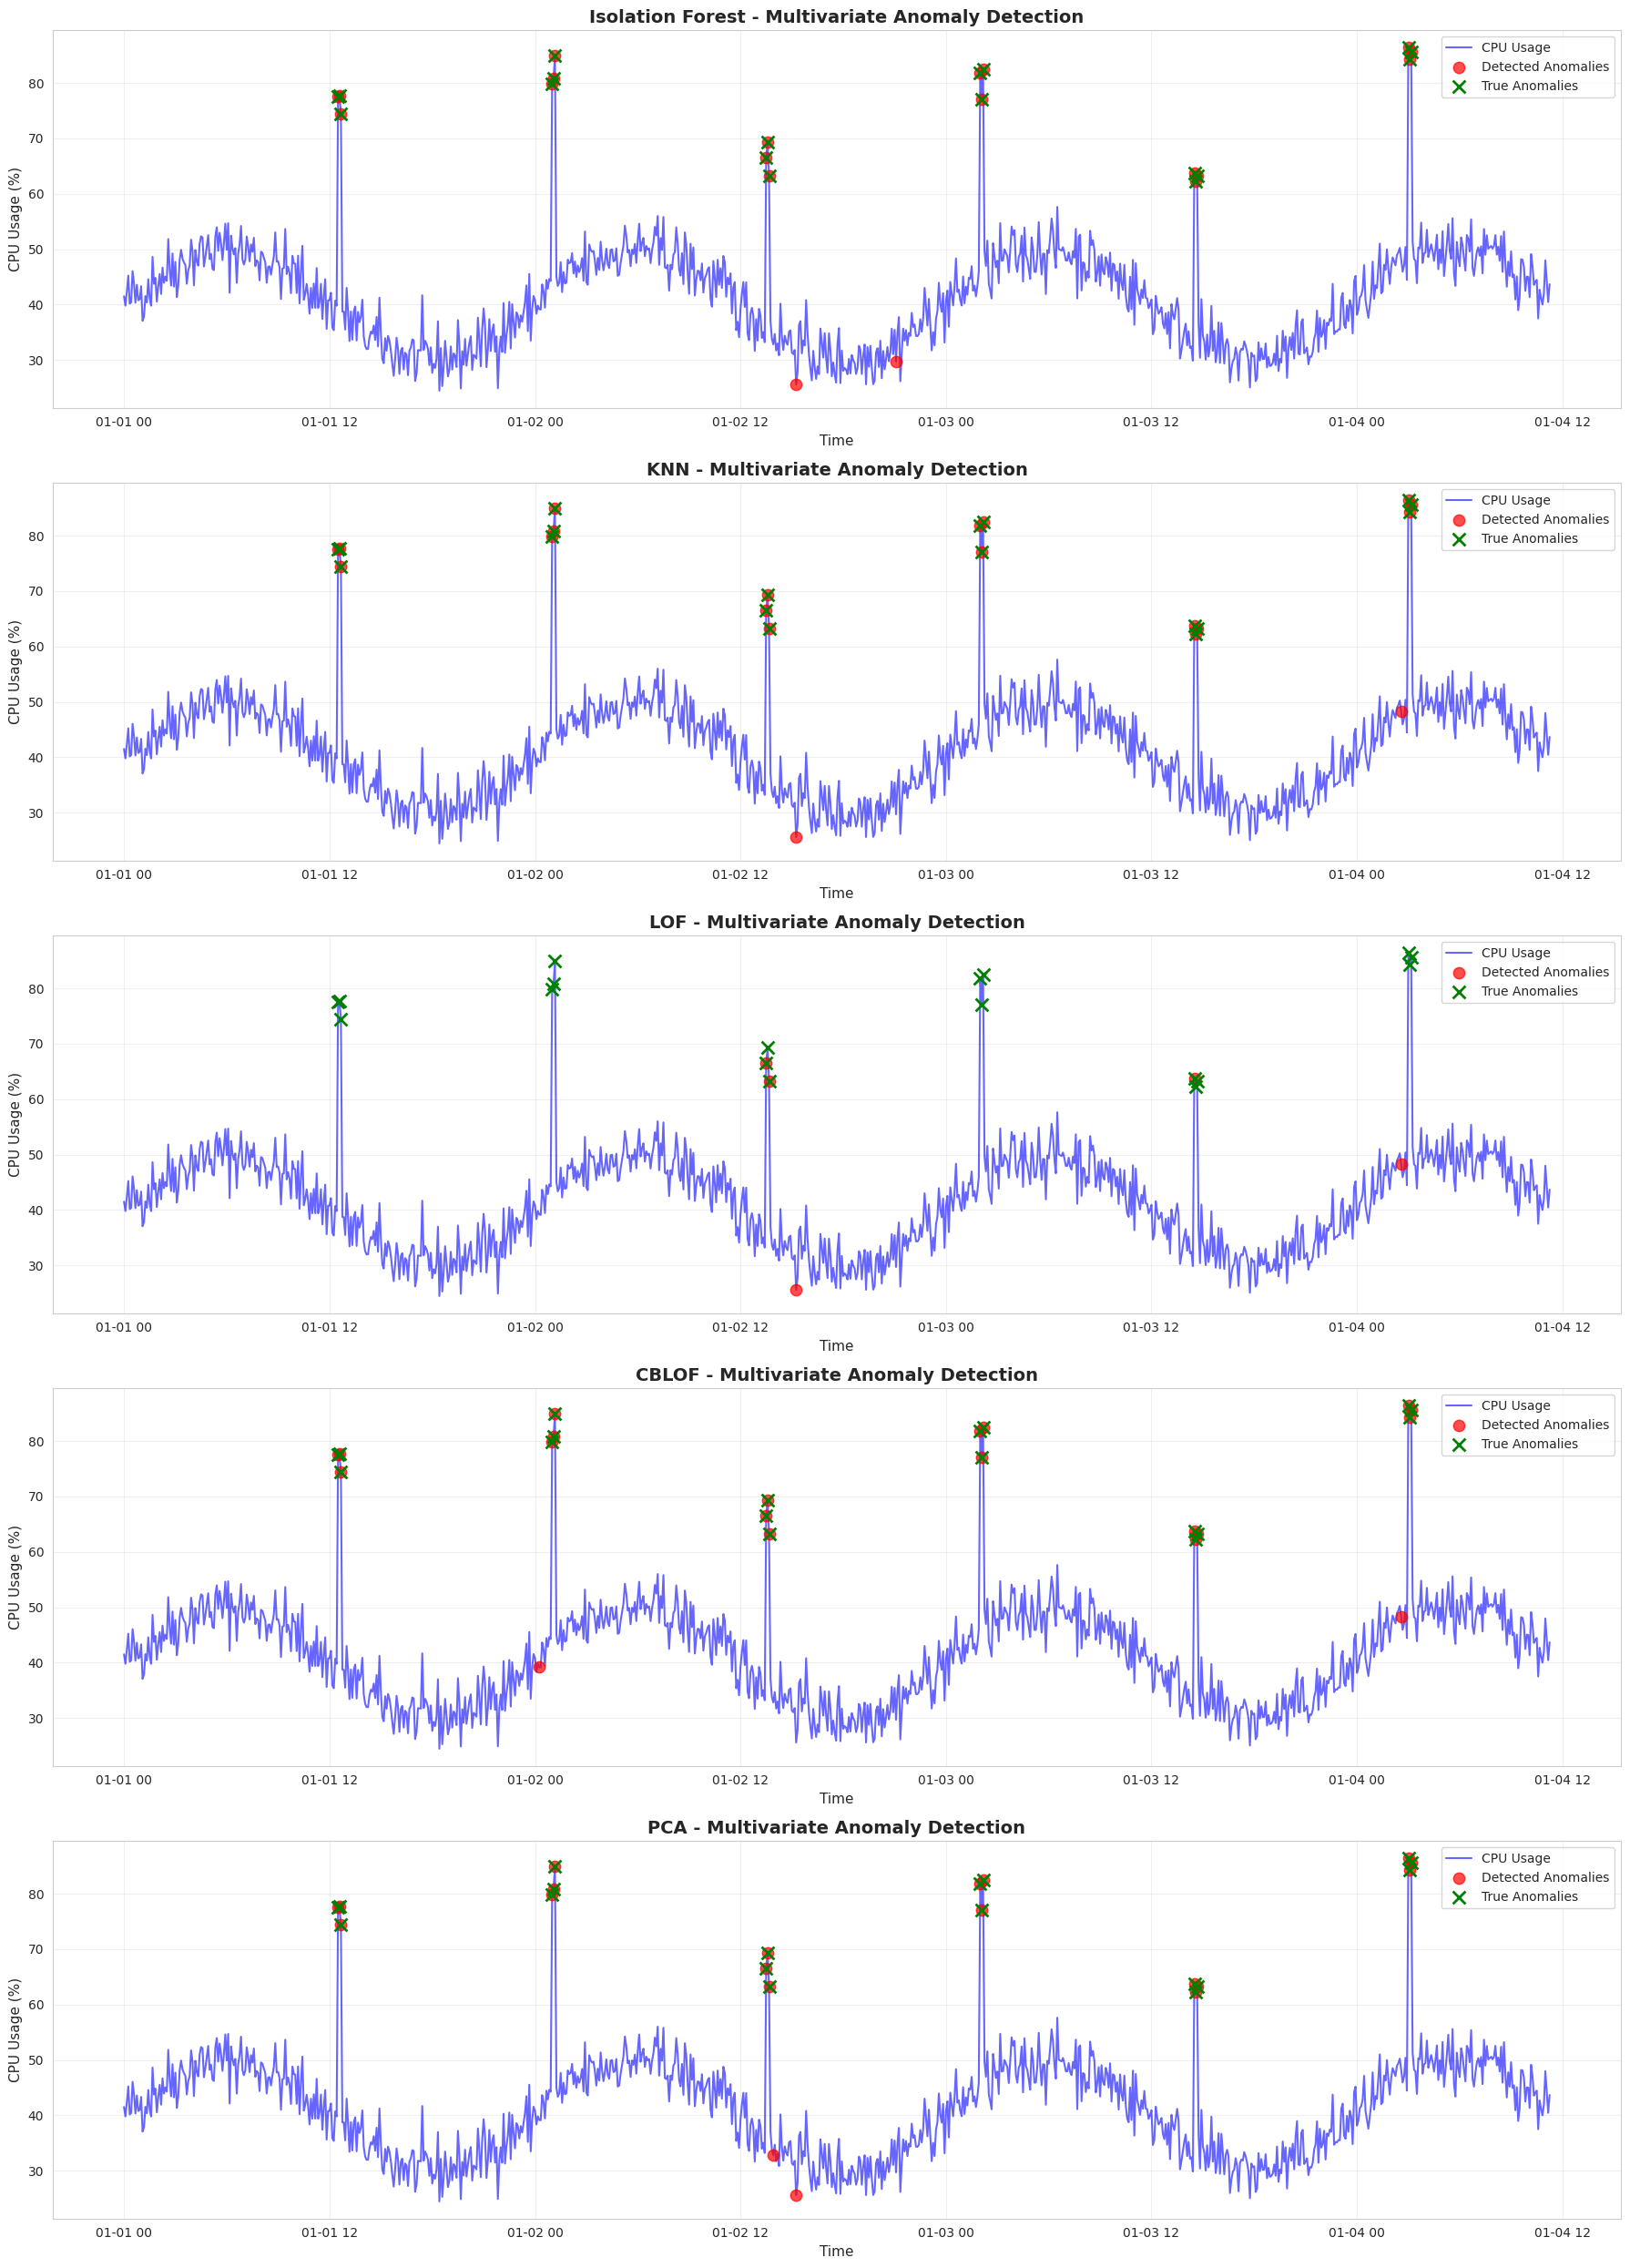

In [11]:
# Visualize multivariate anomaly detection results
fig, axes = plt.subplots(len(algorithms_multi), 1, figsize=(18, 5*len(algorithms_multi)))

if len(algorithms_multi) == 1:
    axes = [axes]

for idx, (name, result) in enumerate(results_multi.items()):
    y_pred = result['predictions']

    # Plot CPU usage as primary metric
    axes[idx].plot(df_multivariate['timestamp'], df_multivariate['cpu_usage'],
                   linewidth=1.5, alpha=0.6, label='CPU Usage', color='blue')

    # Highlight detected anomalies
    anomaly_mask = y_pred == 1
    axes[idx].scatter(df_multivariate[anomaly_mask]['timestamp'],
                      df_multivariate[anomaly_mask]['cpu_usage'],
                      color='red', s=80, marker='o', alpha=0.7,
                      label='Detected Anomalies', zorder=5)

    # Highlight true anomalies
    true_anomaly_mask = y_true_multi == 1
    axes[idx].scatter(df_multivariate[true_anomaly_mask]['timestamp'],
                      df_multivariate[true_anomaly_mask]['cpu_usage'],
                      color='green', s=100, marker='x', linewidths=2,
                      label='True Anomalies', zorder=6)

    axes[idx].set_title(f'{name} - Multivariate Anomaly Detection',
                        fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Time', fontsize=11)
    axes[idx].set_ylabel('CPU Usage (%)', fontsize=11)
    axes[idx].legend(fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Algorithm Comparison and Evaluation


Algorithm Comparison (Multivariate):


,Algorithm,Accuracy,Precision,Recall,F1-Score,Detected
0,Isolation Forest,0.998,0.9,1.000000,0.947368,20
1,KNN,0.998,0.9,1.000000,0.947368,20
3,CBLOF,0.998,0.9,1.000000,0.947368,20
4,PCA,0.998,0.9,1.000000,0.947368,20
2,LOF,0.983,0.6,0.166667,0.260870,5


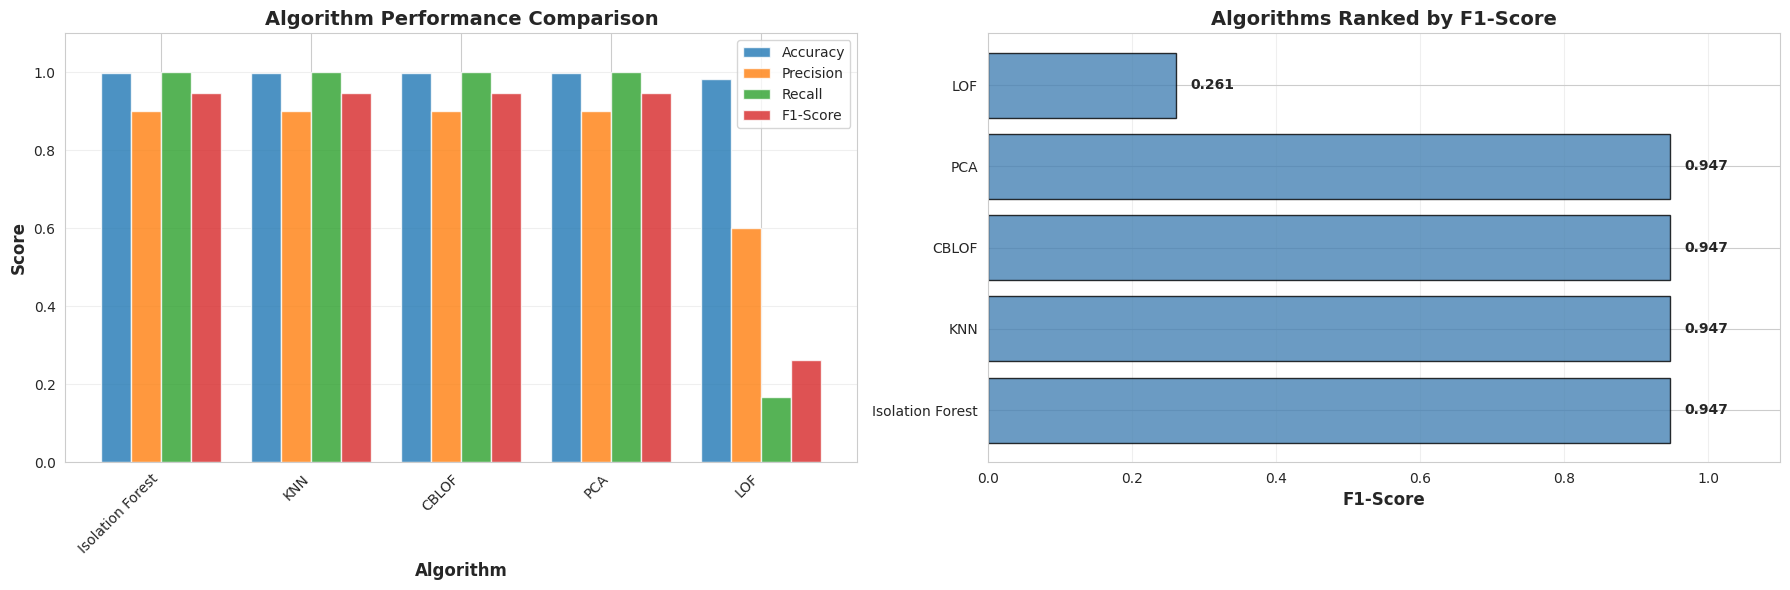

In [12]:
# Compare all algorithms
comparison_data = []

for name, result in results_multi.items():
    y_pred = result['predictions']

    # Calculate metrics
    true_positives = ((y_pred == 1) & (y_true_multi == 1)).sum()
    false_positives = ((y_pred == 1) & (y_true_multi == 0)).sum()
    false_negatives = ((y_pred == 0) & (y_true_multi == 1)).sum()
    true_negatives = ((y_pred == 0) & (y_true_multi == 0)).sum()

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (true_positives + true_negatives) / len(y_pred)

    comparison_data.append({
        'Algorithm': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Detected': int(y_pred.sum())
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\nAlgorithm Comparison (Multivariate):")
print("="*80)
display(comparison_df)

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Metrics comparison
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
x_pos = np.arange(len(comparison_df))
width = 0.2

for i, metric in enumerate(metrics_to_plot):
    axes[0].bar(x_pos + i*width, comparison_df[metric], width,
                label=metric, alpha=0.8)

axes[0].set_xlabel('Algorithm', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[0].set_title('Algorithm Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos + width * 1.5)
axes[0].set_xticklabels(comparison_df['Algorithm'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_ylim(0, 1.1)

# Plot 2: F1-Score ranking
axes[1].barh(comparison_df['Algorithm'], comparison_df['F1-Score'],
             color='steelblue', alpha=0.8, edgecolor='black')
axes[1].set_xlabel('F1-Score', fontsize=12, fontweight='bold')
axes[1].set_title('Algorithms Ranked by F1-Score', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='x')
axes[1].set_xlim(0, 1.1)

# Add value labels
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(v + 0.02, i, f'{v:.3f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

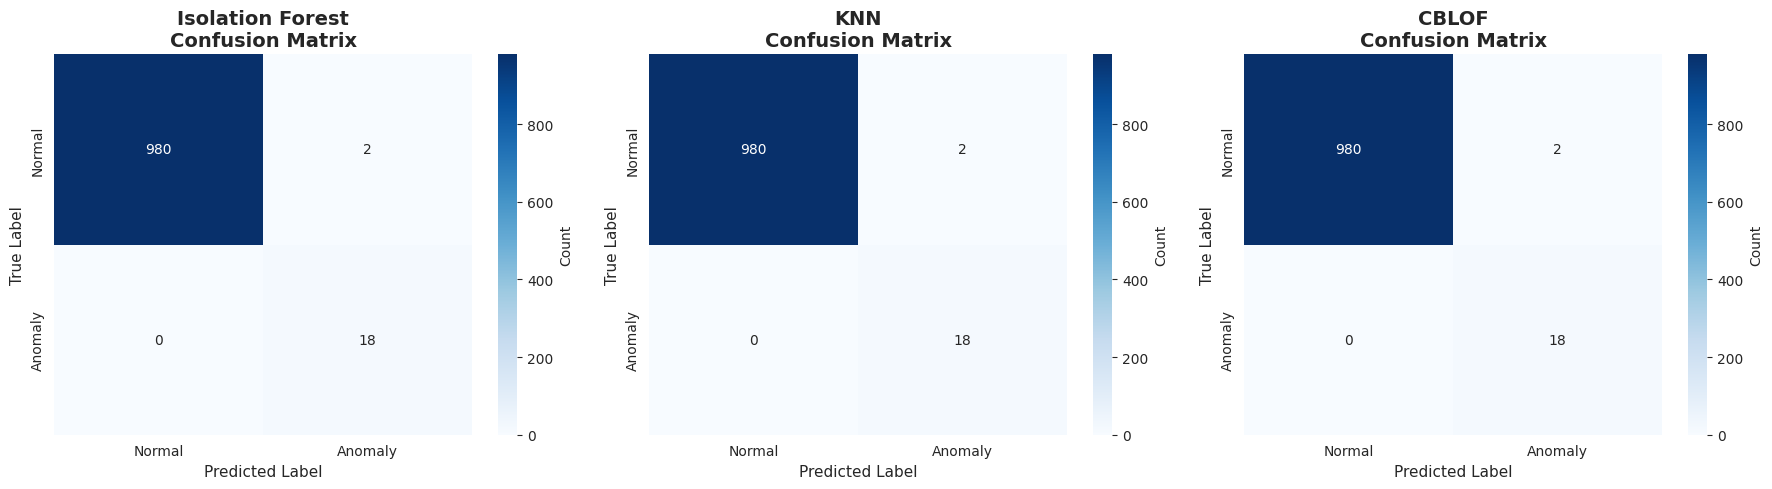

In [13]:
# Plot confusion matrices for best performing algorithms
best_algorithms = comparison_df.head(3)['Algorithm'].values

fig, axes = plt.subplots(1, len(best_algorithms), figsize=(18, 5))

if len(best_algorithms) == 1:
    axes = [axes]

for idx, name in enumerate(best_algorithms):
    y_pred = results_multi[name]['predictions']
    cm = confusion_matrix(y_true_multi, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'],
                ax=axes[idx], cbar_kws={'label': 'Count'})

    axes[idx].set_title(f'{name}\nConfusion Matrix',
                        fontsize=14, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

## 5. Real-World Dataset Example

Apply anomaly detection to a real-world credit card fraud dataset.

In [14]:
# Load credit card fraud dataset (sample)
# Using a smaller sample for demonstration
print("Loading credit card fraud dataset...")

url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"

try:
    # Load dataset
    df_credit = pd.read_csv(url)

    # Sample for computational efficiency (use first 5000 rows)
    df_credit = df_credit.head(5000).copy()

    print(f"\nDataset loaded successfully!")
    print(f"Shape: {df_credit.shape}")
    print(f"\nClass distribution:")
    print(df_credit['Class'].value_counts())
    print(f"\nFraud percentage: {(df_credit['Class'].sum()/len(df_credit))*100:.2f}%")

    display(df_credit.head())

except Exception as e:
    print(f"Error loading dataset: {e}")
    print("Creating synthetic credit card data instead...")

    # Create synthetic data if download fails
    n = 5000
    np.random.seed(42)

    df_credit = pd.DataFrame({
        'V1': np.random.randn(n),
        'V2': np.random.randn(n),
        'V3': np.random.randn(n),
        'V4': np.random.randn(n),
        'Amount': np.random.gamma(2, 20, n),
        'Class': np.random.choice([0, 1], n, p=[0.998, 0.002])
    })

    # Make fraud cases more extreme
    fraud_idx = df_credit[df_credit['Class'] == 1].index
    for col in ['V1', 'V2', 'V3', 'V4']:
        df_credit.loc[fraud_idx, col] *= 5
    df_credit.loc[fraud_idx, 'Amount'] *= 10

    display(df_credit.head())

Loading credit card fraud dataset...

Dataset loaded successfully!
Shape: (5000, 31)

Class distribution:
Class
0    4997
1       3
Name: count, dtype: int64

Fraud percentage: 0.06%


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
# Prepare data
feature_cols = [col for col in df_credit.columns if col not in ['Class', 'Time']]
X_credit = df_credit[feature_cols].values
y_credit = df_credit['Class'].values

# Standardize
scaler_credit = StandardScaler()
X_credit_scaled = scaler_credit.fit_transform(X_credit)

# Calculate contamination rate
contamination_rate = y_credit.sum() / len(y_credit)
print(f"Using contamination rate: {contamination_rate:.4f}")

# Apply anomaly detection
algorithms_credit = {
    'Isolation Forest': IForest(contamination=contamination_rate, random_state=42),
    'KNN': KNN(contamination=contamination_rate),
    'LOF': LOF(contamination=contamination_rate)
}

print("\nDetecting fraud using PyOD algorithms...\n")
print("="*80)

results_credit = {}

for name, model in algorithms_credit.items():
    print(f"\nTraining {name}...")

    # Fit and predict
    model.fit(X_credit_scaled)
    y_pred = model.predict(X_credit_scaled)

    results_credit[name] = y_pred

    # Evaluation
    print(f"\n{name} Results:")
    print("-" * 80)
    print(classification_report(y_credit, y_pred,
                                target_names=['Normal', 'Fraud']))

print("\n" + "="*80)

Using contamination rate: 0.0006

Detecting fraud using PyOD algorithms...


Training Isolation Forest...

Isolation Forest Results:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4997
       Fraud       0.00      0.00      0.00         3

    accuracy                           1.00      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       1.00      1.00      1.00      5000


Training KNN...

KNN Results:
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00      4997
       Fraud       0.00      0.00      0.00         3

    accuracy                           1.00      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       1.00      1.00      1.00      5000


Training LOF...

LO

## 6. Conclusion and Best Practices

### Key Takeaways:

#### 1. Algorithm Selection:
- **Isolation Forest**: Fast, works well with high-dimensional data, good for global anomalies
- **KNN**: Good for local anomalies, intuitive, but slower on large datasets
- **LOF**: Excellent for local outliers, handles varying densities well
- **CBLOF**: Good for cluster-based anomalies, interpretable results
- **One-Class SVM**: Effective for complex decision boundaries, slower training

#### 2. Contamination Parameter:
- Set based on expected anomaly rate in your data
- Too high: Many false positives
- Too low: Missed anomalies
- Use domain knowledge when possible

#### 3. Feature Engineering:
- Always standardize/normalize features
- Consider temporal features for time series
- Remove highly correlated features
- Domain-specific feature creation improves results

#### 4. Evaluation Metrics:
- **Precision**: How many detected anomalies are truly anomalous
- **Recall**: How many true anomalies were detected
- **F1-Score**: Balance between precision and recall
- Consider business context (false positives vs false negatives cost)

#### 5. Best Practices:
- Use ensemble methods (combine multiple algorithms)
- Validate results with domain experts
- Monitor model performance over time
- Retrain periodically as patterns evolve
- Set appropriate alerting thresholds

#### 6. PyOD Advantages:
- 40+ algorithms in unified API
- Easy to compare multiple methods
- Well-documented and maintained
- Includes combination and ensemble methods
- Good performance on various data types

### When to Use Each Approach:
- **Univariate**: Single sensor monitoring, simple threshold-based alerts
- **Multivariate**: Complex system monitoring, correlated anomalies
- **Ensemble**: Critical applications requiring high accuracy

### Next Steps:
- Explore deep learning methods (AutoEncoder, VAE) for complex patterns
- Implement online/streaming anomaly detection
- Use SHAP values for anomaly explanation
- Deploy models in production with monitoring